<font color=orange size=4>Results visualization</font><br />
<font color=orange size=3>Aims:</font><br />
<font color=gray size=2.5>
    &#8195;1. read the files of result and calculate the comparison indicators<br />
    &#8195;2. compare the solutions of three algorithms with the best known one<br />
    &#8195;3. visualize the best and average objective values of three algorithms
</font><br />
<font color=orange size=3>Input:</font><br />
<font color=gray size=2.5>
    &#8195;path (string) - where the results stored
</font><br />
<font color=orange size=3>Outputs:</font><br />
<font color=gray size=2.5>
    &#8195;1. the basic information of studied instance and its best known solution    
    &#8195;2. the performances of each algorithm, including:<br />
    &#8195;&#8195;- the minimun, maximum and average objective values<br />
    &#8195;&#8195;- average CPU run time in minutes in all runs<br />
    &#8195;&#8195;- a figure of its best solution<br />
    &#8195;3. figures of the best and average objective values of three algorithms<br />
</font>

<font color=green size=3>**The notebook is organized as follow:**</font><br />
<font color=gray size=2.5>
    &#8195;Part 1: initial, for setting the path of results<br />
    &#8195;Part 2: reads the result files and performs calculations<br />
    &#8195;Part 3: plots the basic information of instance and its best known solution<br />
    &#8195;Part 4: plots the best solution from each algorithm and their performances<br />
    &#8195;Part 5: plots the converging processes of objective value</font>

<font color=green size=2.5>**Part 1 Please set the path of results**</font>

In [1]:
"""
Environment: Python 3.7.3, IDE: Jupyter Notebook, CPU: 3.0GHz
"""
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = 'Results\\Instance_1_6\\results\\' # path of results of instance 6

<font color=green size=2.5>**Part 2 reads files and performs some calculations**</font>

In [2]:
solname = {1: "Origin ABC", 2: "Semi-enhanced ABC", 3: "Enhanced ABC"} # algorithm name
setname = {'1': "vrpnc", '2': "Kelly"} # instance set name

algoname = [] # save the algorithm name
time = [] # save the average time of each run with different algorithm

'read the instance file for information and figures'
# pointers for the beginnings of each section of instance file
coordinate_begin = -1 # customers coordinate section
demand_begin = -1 # customers demand section
origin_begin = -1 # depot coordinate section

# for those instances without capacity and duration constraints, set its constraints as 9999
Duration = 9999
Capacity = 9999
# for those instances without considering service time, set its service time as 0
ServiceTime = 0 

pathsplit = path.split('\\')
nm = pathsplit[1].split('_') # get the instance number

# find out the file name of studied instance 
if int(nm[1]) == 1:        
    instances = 'CMT' + nm[2] + '.vrp'
    solution = 'CMT' + nm[2] + '.sol'
elif int(nm[1]) == 2:
    instances = 'Golden_' + nm[2] + '.vrp'
    solution = 'Golden_' + nm[2] + '.sol'

with open('Instances\\'+ instances) as lines:
    for line in lines:
        # BestKnown - known best solution
        if ('COMMENT' in line):
            a = line.replace("\n", "")
            b = a.split(': ')
            BestKnown = float(b[1])
        # Dimension - total number of vertices and depot
        if ('DIMENSION' in line):
            a = line.replace("\n", "")
            b = a.split(': ')
            Dimension = int(b[1])
        # Capacity - the maximum number of customers(demands) that a vehicle can take
        if ('CAPACITY' in line):
            a = line.replace("\n", "")
            b = a.split(': ')
            Capacity = int(b[1])
        # Duration - the maximum total number of travel distance and service time that a vehicle can travel
        if ('DISTANCE' in line):
            a = line.replace("\n", "")
            b = a.split(': ')
            Duration = int(float(b[1]))
        # ServiceTime - service time at each vertex
        if ('SERVICE_TIME' in line):
            a = line.replace("\n", "")
            b = a.split(': ')
            ServiceTime = int(float(b[1]))
        # Vehicles - the minimum number of vehicles needed to serve all the customers
        if ('VEHICLES' in line):
            a = line.replace("\n", "")
            b = a.split(': ')
            Vehicles = int(b[1])
        # x,y of vertices
        if ('NODE_COORD_SECTION' in line):
            Coordinates = np.zeros((Dimension, 2))
            coordinate_begin = 1
            continue
        if coordinate_begin > 0 and coordinate_begin < Dimension:
            a = line.replace("\n", "")
            b = a.split(' ')
            Coordinates[coordinate_begin][0] = float(b[1])
            Coordinates[coordinate_begin][1] = float(b[2])
            coordinate_begin = coordinate_begin + 1
        # x,y of depot
        if ('DEPOT_SECTION' in line):
            origin_begin = 1
            demand_begin = -1
            continue
        if origin_begin == 1:
            a = line.replace("\n", "")
            b = a.split(' ')
            Coordinates[0][0] = float(b[0])
            Coordinates[0][1] = float(b[1])
            origin_begin = origin_begin + 1
        # Demand - the number of customers at each vertex
        if ('DEMAND_SECTION' in line):
            coordinate_begin = -1
            demand_begin = 1
            Demand = [0]
            continue
        if demand_begin > 0 and demand_begin < Dimension:
            a = line.replace("\n", "")
            b = a.split(' ')
            Demand.append(float(b[1]))
            demand_begin = demand_begin + 1

'read the solution file for the best known solution'
linenumber = 0
Vehicles = 0
with open('Instances\\' + solution) as lines:
    for line in lines:
        linenumber += 1
        if linenumber == 2:
            a = line.replace("\n", "").replace("  ", " ")
            Vehicles = int(a)
            solroutes = [[0] for i in range(Vehicles)]
        if linenumber > 4:
            a = line.replace("\n", "").replace("  ", " ")
            b = a.split(' ')
            solroutes[linenumber - 5] = list(map(int, b[7:len(b)]))

'read the result files of each algorithm and calculations'
result = {'algorithm': [], 'run': [], 'minfitness': [], 'allfitness': [], 'solution': []}
names = os.listdir(path) # get the file names of results
algocount = sum(map(lambda x : 'timers' in x , names)) # identify the number of algorithms
runs = int(sum(map(lambda x : 'feasible_fitness' in x , names))/algocount)  # identify the runs in the experiments
minfitness = [[] for i in range(3)] # store the minimum objective value of each run
allfitness = [[] for i in range(3)] # store coverging process of the objective value of each run
time = [[] for i in range(3)] # store the average CPU run time in minutes for each algorithm
for name in names: # read each file
    if name.endswith('.npy') and name.startswith('feasible_solution'): # select result files
        namesplit = name.split('-')
        if len(namesplit) == 3:
            result['algorithm'].append(int(re.sub("\D","",namesplit[1]))) # algorithm number, 1 origin, 2 semi-enhanced and 3 enhanced
            result['run'].append(int(re.sub("\D","",namesplit[2]))) # run number, start from 1
            result['solution'].append(np.load(path+name)) # solutions in straightforward representation scheme
            result['allfitness'].append(np.load(path+'feasible_fitness-'+namesplit[1]+'-'+namesplit[2]))
            result['minfitness'].append(min(np.load(path+'feasible_fitness-'+namesplit[1]+'-'+namesplit[2])))
    elif name.startswith('timers'):
        namesplit = name.split('-')
        size = int(re.sub("\D","",namesplit[2])) # size of employed bee
        iterations = int(re.sub("\D","",namesplit[3])) # iterations in each run
        timers = np.loadtxt(path+name) # read the records of CPU run time
        algon = int(re.sub("\D","",namesplit[1]))-1 # get the algorithm number
        time[algon] = (timers[runs-1]-timers[0])/(runs-1)/60 # calculate the average CPU run time in minutes

df = pd.DataFrame(result) # turn the dictionary into dataframe for manipulation
df.sort_values(by=["algorithm","minfitness"], inplace=True, ascending=[True,True]) # sort the results by algorithm type and its best objective value
algo = df['algorithm'].value_counts().index.sort_values() # list the algorithm number
for i in range(len(algo)):
    algoname.append(solname.get(algo[i], None)) # get the algorithm name

for i in range(len(df)):
    # put the best objective value from each run in the list, each algorithm has its own list, for calculate the average objective value   
    minfitness[df['algorithm'].values[i]-1].append(df['minfitness'].values[i])
    allfitness[df['algorithm'].values[i]-1].append(df['allfitness'].values[i])

name = [] 
for i in range(Vehicles):
    name.append('Route' + str(i+1)) # generate the name for legend

<font color=green size=2.5>**Part 3 plots the basic information of instance and its best known solution**</font>

Instance: vrpnc 6
Known best solution：555.43
Number of customers：50
Capacity：160
Duration：200
Service time：10
Number of vehicles：6


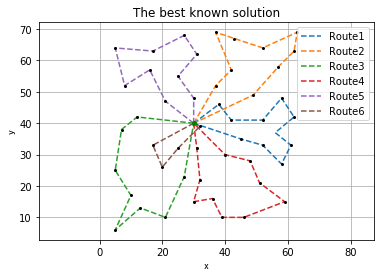

In [3]:
print('Instance: %s %s\nKnown best solution：%s\nNumber of customers：%s\nCapacity：%s\nDuration：%s\nService time：%s\nNumber of vehicles：%s' 
      % (setname.get(nm[1], None), nm[2], BestKnown, Dimension-1, Capacity, Duration, ServiceTime, Vehicles))
x, y = np.hsplit(np.array(Coordinates),2)
routes = [[] for i in range(Vehicles)]  # routes for plotting purpose

for i in range(Vehicles):
    routes[i] = Coordinates[solroutes[i]] # 
    xx, yy = np.hsplit(routes[i], 2)
    plt.plot(xx, yy, '--')            
plt.plot(x[0], y[0],  '.', color='green', markersize=8, label='Start-End')
plt.plot(x[1:len(x)-1],y[1:len(y)-1], '.', color='black', markersize=4, label='Pick-up Location')                                
plt.xlabel('x', fontproperties='SimHei')
plt.ylabel('y', fontproperties='SimHei')
plt.grid(True)
plt.title('The best known solution')
plt.legend(name,loc=1)
plt.axis('equal')
plt.show()

<font color=green size=2.5>**Part 4 plots the best solution from each algorithm and their CPU run time in minutes**</font><br />
    Note: for vrpnc14, the original algorithm ran on a 1.3 GHz computer, NOT the 3.0 GHz computer.

The experiment was conducted with solution size 25 in 100000 iterations for 20 runs
***********Origin ABC algorithm *****************
the minimum fitness = 555.430236
the maximum fitness = 568.566459
the average fitness = 565.027776
the standard deviation of fitness of 20 runs = 2.773398
the deviation of ABC best from the best known solution = 0.00%
the average CPU run time in minutes = 11.583333


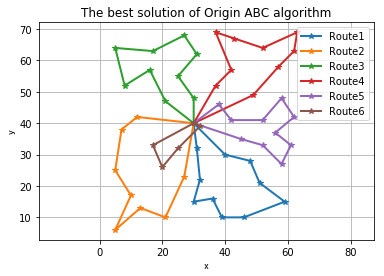

***********Semi-enhanced ABC algorithm *****************
the minimum fitness = 558.928393
the maximum fitness = 564.673141
the average fitness = 561.872741
the standard deviation of fitness of 20 runs = 1.692644
the deviation of ABC best from the best known solution = 0.63%
the average CPU run time in minutes = 11.811404


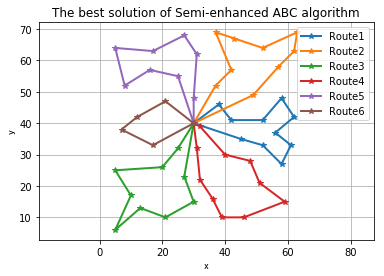

***********Enhanced ABC algorithm *****************
the minimum fitness = 555.430236
the maximum fitness = 566.457530
the average fitness = 560.350700
the standard deviation of fitness of 20 runs = 2.497950
the deviation of ABC best from the best known solution = 0.00%
the average CPU run time in minutes = 11.315789


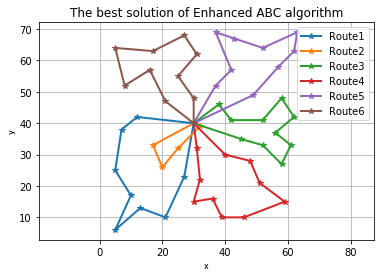

In [4]:
'print the experiment results and draw the figures of solution'
print('The experiment was conducted with solution size %s in %s iterations for %s runs' % (size, iterations, runs))    
for i in range(len(algo)):
    print('***********%s algorithm *****************' 
          % (solname.get(algo[i], None)))
    print('the minimum fitness = %f' 
          % (min(minfitness[algo[i]-1])))
    print('the maximum fitness = %f' 
          % (max(minfitness[algo[i]-1])))
    print('the average fitness = %f' 
          % (np.mean(minfitness[algo[i]-1])))
    print('the standard deviation of fitness of %d runs = %f' 
          % (runs, np.std(minfitness[algo[i]-1])))
    print('the deviation of ABC best from the best known solution = %.2f%%' 
          % ((min(minfitness[algo[i]-1]) - BestKnown)/BestKnown*100))
    print('the average CPU run time in minutes = %f' 
          % (time[algo[i]-1]))

    plt.figure(i)
    tra = df['solution'].values[i*runs]
    trace = [[0] for i in range(Vehicles)]
    t = 0
    for j in range(len(tra)): # generate trace of each vehicle from solution
        if tra[j] != 0:
            trace[t].extend([tra[j]])
        else:
            trace[t].extend([0])
            t += 1
    trace[Vehicles-1].extend([0])
    routes = [[] for i in range(Vehicles)]
    for j in range(Vehicles): # draw the traces
        routes[j] = Coordinates[trace[j]] # obtain the coordinates of customers served by vehicle j
        x, y = np.hsplit(routes[j], 2)
        plt.plot(x, y, '-*', linewidth = 2) # plot the traces
    plt.xlabel('x', fontproperties='SimHei')
    plt.ylabel('y', fontproperties='SimHei')
    plt.title('The best solution of ' + solname.get(algo[i], None) + ' algorithm')
    plt.grid(True)
    plt.legend(name,loc=1)
    plt.axis('equal')
    plt.show()

<font color=green size=2.5>**Part 5 plots the converging processes of objective value, including the best solution and average solution**</font>

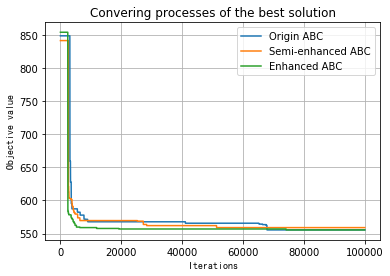

In [5]:
plt.figure(len(algo) + 1) # best fitness
for i in range(len(algo)):
    plt.plot(df['allfitness'].values[i*runs]) # find the minimum objective value
plt.legend(algoname,loc=1)
plt.title('Convering processes of the best solution')
plt.xlabel('Iterations', fontproperties='SimHei')
plt.ylabel('Objective value', fontproperties='SimHei')
plt.grid(True)
plt.show()